# Monte Carlo in spinfoams

Description of the notebook

## Setup

In [1]:
using CSV
using DataFrames
using HalfIntegers, JLD2, Distributions, Random
using LaTeXStrings

In [2]:
using Statistics
using StatsBase
using StatsPlots

In [3]:
theme(:default)
default(
    markerstrokewidth = 0,
    markerstrokealpha = 0,
    grid = :true,
    gridlinewidth = 0.5,
    fontfamily="Computer Modern",
    framestyle=:box,
    size=(800,300),
)
scalefontsizes(1.3)

In [4]:
function intertwiner_range(j1, j2, j3, j4)

    if (2j1 + 2j2) % 2 != (2j3 + 2j4) % 2
        return (), 0
    end

    imin = max(abs(j1 - j2), abs(j3 - j4))
    imax = min(j1 + j2, j3 + j4)

    range = imax >= imin ? (imin, imax) : ()
    size = imax >= imin ? Int(imax - imin) + 1 : 0

    (range, size)

end

intertwiner_range (generic function with 1 method)

# Test the sampler

To test if the sampler we employ in MC summations is uniform we map it to the Integer line with an arbitrary order. We take a sample and check hystogram, mean variance and skewness. 

## Utility functions 

This function list all the possible configurations. To execute only once. It takes a while.

In [5]:
# store self-energy spins configurations for all partial cutoffs up to cutoff
function self_energy_spins_conf_Dict(
    cutoff,
    jb::HalfInt,
    configs_path::String,
    step = half(1),
)

    # loop over partial cutoffs
    for pcutoff = 0:step:cutoff

        # generate a Dict (hash table) of all spins to compute
        spins_configurations = Dict{Vector{HalfInt8},Int}()

        index_in_list = 0

        for j23::HalfInt8 = 0:step:pcutoff,
            j24::HalfInt8 = 0:step:pcutoff,
            j25::HalfInt8 = 0:step:pcutoff,
            j34::HalfInt8 = 0:step:pcutoff,
            j35::HalfInt8 = 0:step:pcutoff,
            j45::HalfInt8 = 0:step:pcutoff

            # skip if computed in lower partial cutoff
            j23 <= (pcutoff - step) &&
                j24 <= (pcutoff - step) &&
                j25 <= (pcutoff - step) &&
                j34 <= (pcutoff - step) &&
                j35 <= (pcutoff - step) &&
                j45 <= (pcutoff - step) &&
                continue

            # skip if any intertwiner range empty
            r2, _ = intertwiner_range(jb, j25, j24, j23)
            r3, _ = intertwiner_range(j23, jb, j34, j35)
            r4, _ = intertwiner_range(j34, j24, jb, j45)
            r5, _ = intertwiner_range(j45, j35, j25, jb)

            isempty(r2) && continue
            isempty(r3) && continue
            isempty(r4) && continue
            isempty(r5) && continue

            # must be computed
            index_in_list += 1
            spins_configurations[[j23, j24, j25, j34, j35, j45]] = index_in_list


        end

        # store partial spins configurations at pctuoff
        @save "$(configs_path)/Dict_configs_pcutoff_$(twice(pcutoff)/2).jld2" spins_configurations

        total_conf = index_in_list

        println("configurations at partial cutoff = $pcutoff: $(index_in_list)")

    end

end

self_energy_spins_conf_Dict (generic function with 2 methods)

In [6]:
# self_energy_spins_conf_Dict(10, half(1), "./MC_sampler_test")

This is the random sampler we use in the MC code

In [7]:
# store Monte Carlo self-energy spins configurations for all partial cutoffs up to cutoff
function self_energy_MC_sampling(
    cutoff,
    Nmc::Int,
    jb::HalfInt,
    MC_configs_path::String,
    step = half(1),
)

    MC_draws = Array{HalfInt8}(undef, 6, Nmc)
    draw_float_sample = Array{Float64}(undef, 1)

    # loop over partial cutoffs
    for pcutoff = step:step:cutoff

        distr = Uniform(0, Int(2 * pcutoff + 1))

        for n = 1:Nmc

            while true

                # sampling j23, j24, j25 for the 4j with spins [j23, j24, j25, jb]
                for i = 1:3
                    rand!(distr, draw_float_sample)
                    MC_draws[i, n] = half(floor(draw_float_sample[1]))
                end

                # sampling j34, j35 for the 4j with spins [j34, j35, jb, j23]
                for i = 4:5
                    rand!(distr, draw_float_sample)
                    MC_draws[i, n] = half(floor(draw_float_sample[1]))
                end

                # sampling j45 for the 4j with spins [j45, jb, j24, j34]
                for i = 6:6
                    rand!(distr, draw_float_sample)
                    MC_draws[i, n] = half(floor(draw_float_sample[1]))
                end

                # skip if computed in lower partial cutoff
                MC_draws[1, n] <= (pcutoff - step) &&
                    MC_draws[2, n] <= (pcutoff - step) &&
                    MC_draws[3, n] <= (pcutoff - step) &&
                    MC_draws[4, n] <= (pcutoff - step) &&
                    MC_draws[5, n] <= (pcutoff - step) &&
                    MC_draws[6, n] <= (pcutoff - step) &&
                    continue

                # check that 4j with spins [j45, jb, j24, j34] satisfies triangular inequalities
                r, _ = intertwiner_range(MC_draws[6, n], jb, MC_draws[2, n], MC_draws[4, n])
                isempty(r) && continue

                # check that 4j with spins [j34, j35, jb, j23] satisfies triangular inequalities
                r, _ = intertwiner_range(MC_draws[4, n], MC_draws[5, n], jb, MC_draws[1, n])
                isempty(r) && continue

                # check that 4j with spins [j23, j24, j25, jb] satisfies triangular inequalities
                r, _ = intertwiner_range(MC_draws[1, n], MC_draws[2, n], MC_draws[3, n], jb)
                isempty(r) && continue

                # check that 4j with spins [jb, j25, j35, j45] satisfies triangular inequalities
                r, _ = intertwiner_range(jb, MC_draws[3, n], MC_draws[5, n], MC_draws[6, n])
                isempty(r) && continue

                # bulk spins have passed all tests -> must be computed
                break

            end

        end

        # store MC spins indices 
        @save "$(MC_configs_path)/MC_draws_pcutoff_$(twice(pcutoff)/2).jld2" MC_draws

    end

end

self_energy_MC_sampling (generic function with 2 methods)

## Analysis 

We precompute the sample with $N_{mc}=100\,000$

In [8]:
Nmc=100000
self_energy_MC_sampling(10, Nmc,  half(1), "../../data/MC_sampler_test")

Load the precomputed samples

In [9]:
@load "../../data/MC_sampler_test/Dict_configs_pcutoff_10.0.jld2" spins_configurations
@load "../../data/MC_sampler_test/MC_draws_pcutoff_10.0.jld2" MC_draws

1-element Vector{Symbol}:
 :MC_draws

Map them into a list

In [10]:
indices_set = Int[]

for mc_index = 1:Nmc
    index_listone = spins_configurations[MC_draws[:, mc_index]]
    push!(indices_set, index_listone)
end

There are a total of

In [11]:
number_of_configs = length(spins_configurations)

549406

Here we compute the expected mean, variance and skewness of a uniform discrete probability distribution between 1 and 549406

In [12]:
expected_mean = (1 + number_of_configs) / 2
expected_skewness = 0.0
expected_var = (number_of_configs^2 - 1) / 12

computed_mean = mean(indices_set)
computed_skewness = skewness(indices_set)
computed_var = var(indices_set)


println("CONFIGURATIONS AT PCUTOFF = 10: $(number_of_configs)")
println("-----------------------------------")
println("expected mean = $(expected_mean)")
println("computed mean = $(computed_mean)")
println("-----------------------------------")
println("expected skewness = $(expected_skewness)")
println("computed skewness = $(computed_skewness)")
println("-----------------------------------")
println("expected var = $(expected_var)")
println("computed var = $(computed_var)")

CONFIGURATIONS AT PCUTOFF = 10: 549406
-----------------------------------
expected mean = 274703.5
computed mean = 274348.8483
-----------------------------------
expected skewness = 0.0
computed skewness = 0.0047761623467499105
-----------------------------------
expected var = 2.515391273625e10
computed var = 2.5089061228226692e10


Plot the histogram by hand since the default function is horrible.

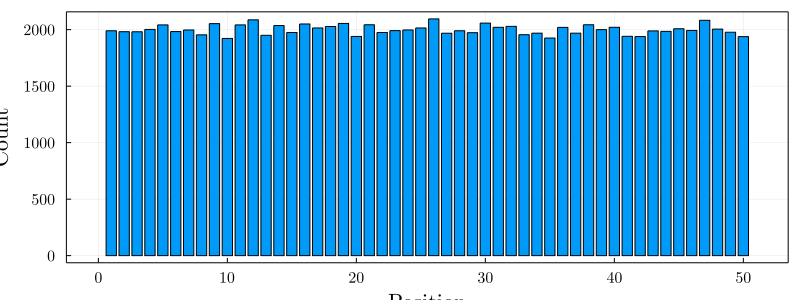

In [13]:
bin = 50
binned_data = [
    length([el for el in indices_set if (t - 1) * number_of_configs / bin < el <= t * number_of_configs / bin]) for t = 1:bin
];
bar(1:bin, binned_data, legend = false, space = 0,ylabel="Count",xlabel="Position")

# Deciding how many trials we want to use

We decide how many trials we want to use to estimate the error we make on the Monte Carlo sum of each layer of the amplitude. 

## Loading Data

Load the data of all the layers

In [14]:
DIRECTORY = "/home/pdona/Desktop/ExportData/data/self_energy/jb_0.5/exact/BF/internal_contributions"
LAYER = Dict()

for k in 0.5:0.5:10.0
    LAYER[k] = DataFrame(
            CSV.File(
                "$(DIRECTORY)/internal_pcutoff_$(k).csv",
                header=false
            ),
        ).Column7
end

Fake MonteCarlo function

In [15]:
function MCSum(vector, Nmc)
    vol = length(vector)
    randomsample = sample(vector,Nmc,replace=true)
    return sum(randomsample)*vol/Nmc
end

MCSum (generic function with 1 method)

In [16]:
exact_layers = [sum(LAYER[k]) for k in 0.5:0.5:10.0];

In [17]:
function relative_error(vector)
    s = std(vector);
    m = mean(vector);
    return 100*s/m
end

relative_error (generic function with 1 method)

## Trials analysis for each layer

We start looking at $10$, $20$, $50$ trials. How can we evaluate what is a good estimate of the error? We look at the boxplot of averages of multiple realizations of $T$ trials

In [18]:
function sample_samples(k,T)
    return [100*(mean([MCSum(LAYER[k],1000) for _ in 1:T])/exact_layers[Integer(2*k)]-1) for _ in 1:100]
end

sample_samples (generic function with 1 method)

In [19]:
test_10trials = DataFrame();
test_20trials = DataFrame();
test_50trials = DataFrame();

test_10trials[!,"Layer"] = vcat([[k for _ in 1:100] for k in 5.0:0.5:10.0]...);
test_10trials[!,"MCestimate"] = vcat([sample_samples(k,10) for k in 5.0:0.5:10.0]...);

test_20trials[!,"Layer"] = vcat([[k for _ in 1:100] for k in 5.0:0.5:10.0]...);
test_20trials[!,"MCestimate"] = vcat([sample_samples(k,20) for k in 5.0:0.5:10.0]...);

test_50trials[!,"Layer"] = vcat([[k for _ in 1:100] for k in 5.0:0.5:10.0]...);
test_50trials[!,"MCestimate"] = vcat([sample_samples(k,50) for k in 5.0:0.5:10.0]...);

There are many options to visualize the distribution with a sample of different layers

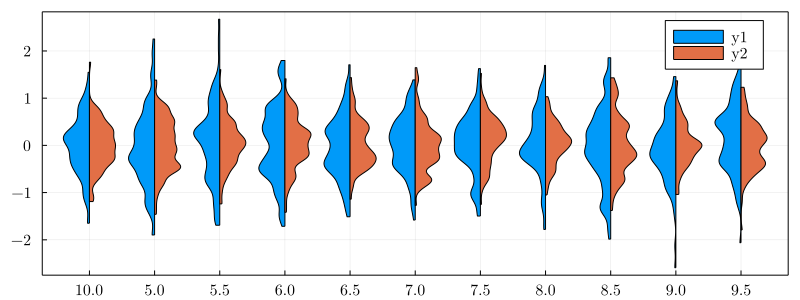

In [20]:
@df test_10trials violin(string.(:Layer),:MCestimate, side = :left)
@df test_20trials violin!(string.(:Layer),:MCestimate,side = :right)

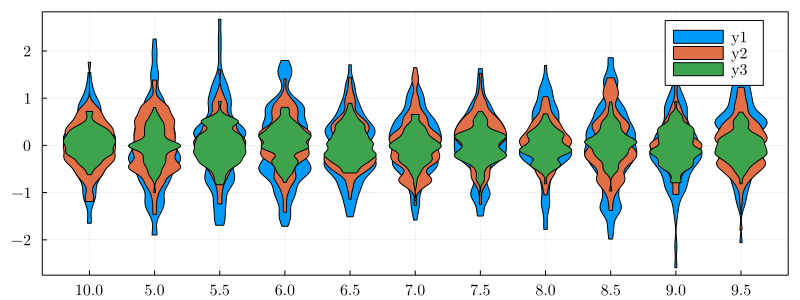

In [21]:
@df test_10trials violin(string.(:Layer),:MCestimate)
@df test_20trials violin!(string.(:Layer),:MCestimate)
@df test_50trials violin!(string.(:Layer),:MCestimate)

With 10 trials we can see from the violin plot that the tails are too large. The estimate of the % error is not reliable. (Maybe I am complaining about useless details. The difference is between $2\to 1$ %)

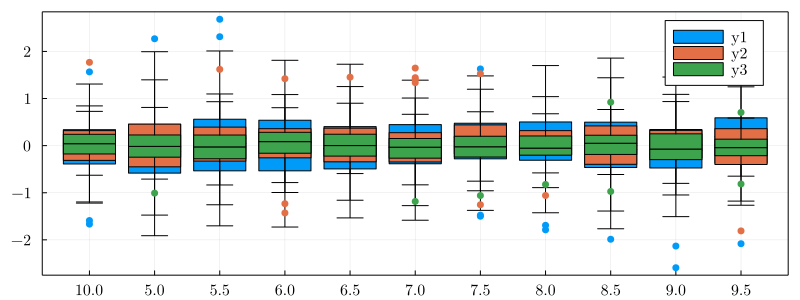

In [22]:
@df test_10trials boxplot(string.(:Layer),:MCestimate)
@df test_20trials boxplot!(string.(:Layer),:MCestimate)
@df test_50trials boxplot!(string.(:Layer),:MCestimate)

We can compare the distribution of the averages using boxplots for which is evident that 10 trials result in a very wide distribution. 20 trials is better and 50 is very narrow. We will settle with 20 for sake of conserving resources. 

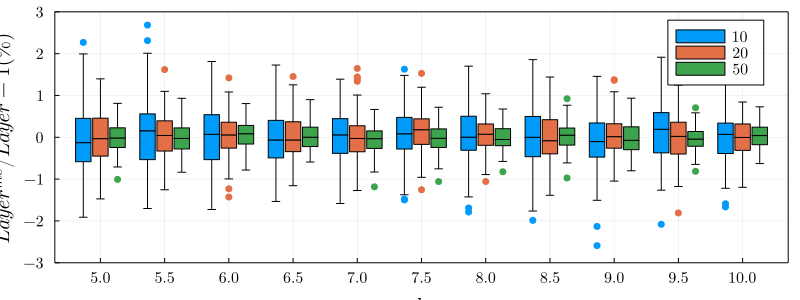

In [23]:
total_df = vcat(test_10trials,test_20trials,test_50trials,source="source");
trialsdict = Dict(1=>10,2=>20,3=>50);
total_df[!,"source"] = [trialsdict[s] for s in total_df[!,"source"]];
boxplots_trials = groupedboxplot(
    string.(total_df.Layer),
    total_df.MCestimate,
    group = total_df.source, 
    xlabel = L"k", 
    ylabel = L"Layer^{mc}/Layer - 1 (\%)",
    ylim=(-3,3),
    )

# Decide how many monte carlo samples we take

We compare the results of MC sampling with $N_{mc}=1\,000$, $N_{mc}=10\,000$, $N_{mc}=100\,000$ samples. We compare with the exact result for the amplitude. 
We estimate the value of the Layers averaging over 20 trials and the error with the standard deviation. Then we sum the average value of the layers and we sum variances

In [24]:
BASE_DATA_DIRECTORY = "../../data";
function get_data(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_1.0/ib_0/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end

function get_self_energy_exact()
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/exact/BF/weight_1.0/ib_0/ampls_cutoff_10.csv",
        ),
    )
end

get_self_energy_exact (generic function with 1 method)

In [25]:
exact_amplitude = get_self_energy_exact().amp[2:end];

In [26]:
layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(1000, trial).amp[id] - get_data(1000, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc1K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc1K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);

In [27]:
relative_Nmc1K = amplitude_Nmc1K./exact_amplitude .-1;
error_relative_Nmc1K = error_Nmc1K./exact_amplitude;

In [28]:
layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(10000, trial).amp[id] - get_data(10000, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc10K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc10K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);

relative_Nmc10K = amplitude_Nmc10K./exact_amplitude .-1;
error_relative_Nmc10K = error_Nmc10K./exact_amplitude;

In [29]:
layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(100000, trial).amp[id] - get_data(100000, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc100K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc100K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);

relative_Nmc100K = amplitude_Nmc100K./exact_amplitude .-1;
error_relative_Nmc100K = error_Nmc100K./exact_amplitude;

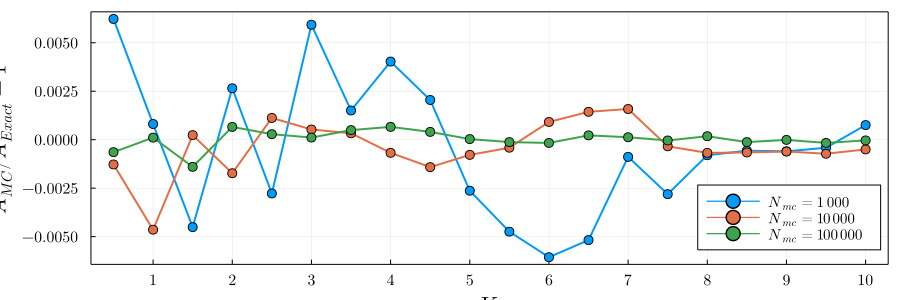

In [30]:
plot1 = plot(0.5:0.5:10,
               [relative_Nmc1K,relative_Nmc10K,relative_Nmc100K],
               label = [L"$N_{mc}=1\,000$" L"$N_{mc}=10\,000$" L"$N_{mc}=100\,000$"],
               #label = ["1K" "10K" "100K"],
               #title = ["Comparison with exact"],
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.85,0.25),
               size = (900, 300),
               ylabel = L"A_{MC}/A_{Exact} -1",
               xlabel = "K",
            #    yerror= [error_relative_Nmc1K,error_relative_Nmc10K],
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               )

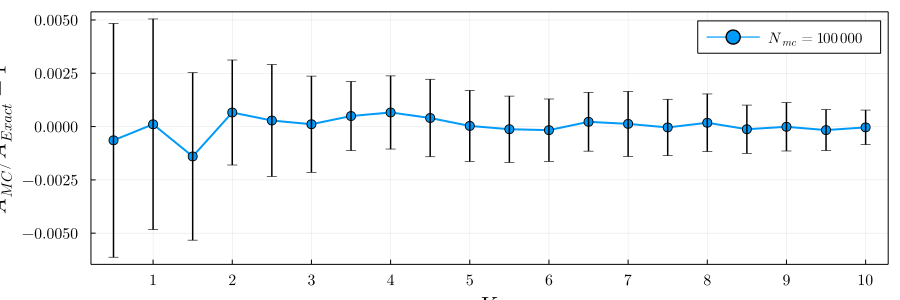

In [31]:
plot2 = plot(0.5:0.5:10,
               relative_Nmc100K,
            #   label = [L"$N_{mc}=1000$",L"$N_{mc}=1000$"],
               label =  L"$N_{mc}=100\,000$",
               #title = ["Comparison with exact"],
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.85,0.90),
               size = (900, 300),
               ylabel = L"A_{MC}/A_{Exact} -1",
               xlabel = "K",
               yerror= error_relative_Nmc100K,
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               )

Even in loglog scale the exact and the MC are the one on top of the other

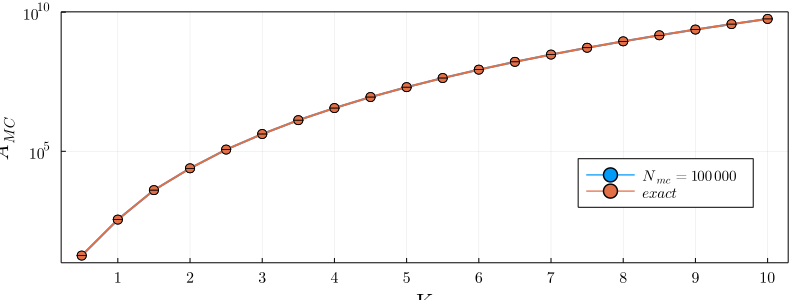

In [32]:
plot3 = plot(0.5:0.5:10,
               [amplitude_Nmc100K,exact_amplitude],
            #   label = [L"$N_{mc}=1000$",L"$N_{mc}=1000$"],
               label =  [L"$N_{mc}=100\,000$" L"exact"],
               #title = ["Comparison with exact"],
               yscale=:log10,
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.80,0.35),
               ylabel = L"A_{MC}",
               xlabel = "K",
               yerror= error_Nmc100K,
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               grid=true
               )

# Fitting the amplitude to find the scaling

We fit the amplitude as a function of the cutoff K using least squares fit. We use as a model the function 
$$ c_2K^{c_1} +  c_3 K^{c_1-1} +  c_4$$
and we perform the fit using only the last 10-ish points.

In [33]:
using LsqFit

In [34]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1) + c[4]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [4.0,1.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], exact_amplitude[10:end], c0)
fit.param

4-element Vector{Float64}:
  8.503364844144004
 15.31002235289734
 26.351277387685812
  4.880323852794268e6

The error is computed automatically by the library. We use the 95% CI.

In [35]:
margin_error(fit, 0.05)

4-element Vector{Float64}:
  0.5676935611320246
 29.805878768043353
 63.720067509758884
  4.813091522427441e6

Visual check that the amplitude is compatible with the fit even with a bad fit!

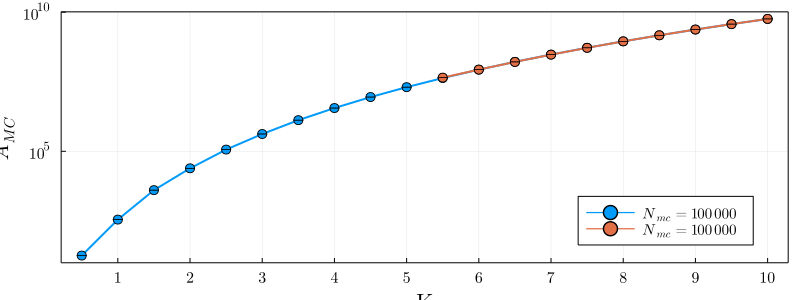

In [36]:
plot3 = plot(0.5:0.5:10,
               amplitude_Nmc100K,
            #   label = [L"$N_{mc}=1000$",L"$N_{mc}=1000$"],
               label =  L"$N_{mc}=100\,000$",
               #title = ["Comparison with exact"],
               yscale=:log10,
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.8,0.20),
               ylabel = L"A_{MC}",
               xlabel = "K",
               yerror= error_Nmc100K,
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               grid=true
               )
plot3 = plot!(5.5:0.5:10,
               [model(K,fit.param) for K in 5.5:0.5:10],
            #   label = [L"$N_{mc}=1000$",L"$N_{mc}=1000$"],
               label =  L"$N_{mc}=100\,000$",
               #title = ["Comparison with exact"],
               yscale=:log10,
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.8,0.20),
               ylabel = L"A_{MC}",
               xlabel = "K",
               yerror= error_Nmc100K,
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               grid=true
               )

The issue with the fit beign so bad has nothing to do with the Monte Carlo estimate. The fit we showed here is done using the exact amplitude. We can repeat it using the MonteCarlo amplitude to obtain very similar results.

In [37]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1) + c[4]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [4.0,1.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], amplitude_Nmc100K[10:end], c0)
fit.param

4-element Vector{Float64}:
  8.51301801310873
 14.813725869977217
 27.359561233381154
  4.871348928907533e6

In [38]:
margin_error(fit, 0.05)

4-element Vector{Float64}:
  0.592319148010625
 30.206997215913248
 62.947549904792965
  4.859805032226445e6

We cannot discriminate between $c_1=8$, $8.5$ or $9$. To circumvent this problem we look at the amplitudes with modified face amplitude 
$$ A_f(j_f) = (2j_f+1) \to (2j_f+1)^\mu$$
using as possible values of $\mu=1/6$, $\mu=0$, and $\mu=-1/6$.

In [39]:
function get_data_mu16(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_0.167/ib_0/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end

function get_self_energy_exact_mu16()
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/exact/BF/weight_0.167/ib_0/ampls_cutoff_10.csv",
        ),
    )
end

exact_amplitude_mu16 = get_self_energy_exact_mu16().amp[2:end];

In [40]:
function get_data_mu0(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_0.0/ib_0/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end

function get_self_energy_exact_mu0()
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/exact/BF/weight_0.0/ib_0/ampls_cutoff_10.csv",
        ),
    )
end

exact_amplitude_mu0 = get_self_energy_exact_mu0().amp[2:end];

In [41]:
function get_data_mum16(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_-0.167/ib_0/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end

function get_self_energy_exact_mum16()
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/exact/BF/weight_-0.167/ib_0/ampls_cutoff_10.csv",
        ),
    )
end

exact_amplitude_mum16 = get_self_energy_exact_mum16().amp[2:end];

In [42]:
layers_trials_mu16 = DataFrame()
for trial in 1:20
    layers_trials_mu16[!,"$(trial)"]=[get_data_mu16(100000, trial).amp[id] - get_data_mu16(100000, trial).amp[id-1] for id in 2:21]
end

layers_average_mu16 =  [mean(row) for row in eachrow(layers_trials_mu16)];
layers_variance_mu16 =  [var(row) for row in eachrow(layers_trials_mu16)];
amplitude_Nmc100K_mu16 = [sum(layers_average_mu16[1:id]) for id in 1:20];
error_Nmc100K_mu16 = sqrt.([sum(layers_variance_mu16[1:id]) for id in 1:20]);


relative_Nmc100K_mu16 = amplitude_Nmc100K_mu16./exact_amplitude_mu16 .-1;
error_relative_Nmc100K_mu16 = error_Nmc100K_mu16./exact_amplitude_mu16;

In [43]:
layers_trials_mu0 = DataFrame()
for trial in 1:20
    layers_trials_mu0[!,"$(trial)"]=[get_data_mu0(100000, trial).amp[id] - get_data_mu0(100000, trial).amp[id-1] for id in 2:21]
end

layers_average_mu0 =  [mean(row) for row in eachrow(layers_trials_mu0)];
layers_variance_mu0 =  [var(row) for row in eachrow(layers_trials_mu0)];
amplitude_Nmc100K_mu0 = [sum(layers_average_mu0[1:id]) for id in 1:20];
error_Nmc100K_mu0 = sqrt.([sum(layers_variance_mu0[1:id]) for id in 1:20]);

relative_Nmc100K_mu0 = amplitude_Nmc100K_mu0./exact_amplitude_mu0 .-1;
error_relative_Nmc100K_mu0 = error_Nmc100K_mu0./exact_amplitude_mu0;

In [44]:
layers_trials_mum16 = DataFrame()
for trial in 1:20
    layers_trials_mum16[!,"$(trial)"]=[get_data_mum16(100000, trial).amp[id] - get_data_mum16(100000, trial).amp[id-1] for id in 2:21]
end

layers_average_mum16 =  [mean(row) for row in eachrow(layers_trials_mum16)];
layers_variance_mum16 =  [var(row) for row in eachrow(layers_trials_mum16)];
amplitude_Nmc100K_mum16 = [sum(layers_average_mum16[1:id]) for id in 1:20];
error_Nmc100K_mum16 = sqrt.([sum(layers_variance_mum16[1:id]) for id in 1:20]);


relative_Nmc100K_mum16 = amplitude_Nmc100K_mum16./exact_amplitude_mum16 .-1;
error_relative_Nmc100K_mum16 = error_Nmc100K_mum16./exact_amplitude_mum16;

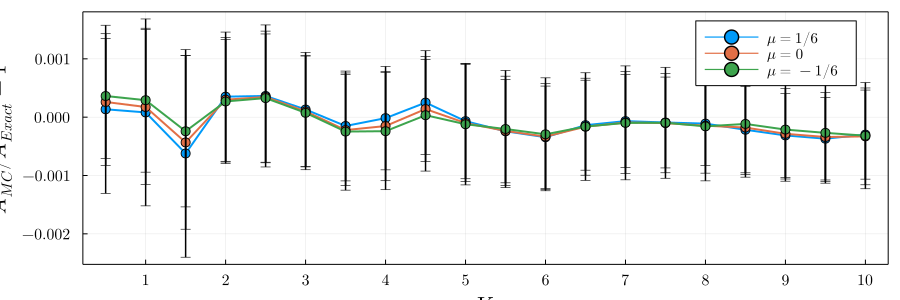

In [45]:
plot(0.5:0.5:10,
   relative_Nmc100K_mu16,
#   label = [L"$N_{mc}=1000$",L"$N_{mc}=1000$"],
   label =  L"$\mu = 1/6$",
   #title = ["Comparison with exact"],
   markershape = [:circle :circle :circle],
   shape = [:circle :circle :circle],
   xticks = 1:1:10,
   legend = (0.85,0.90),
   size = (900, 300),
   ylabel = L"A_{MC}/A_{Exact} -1",
   xlabel = "K",
   yerror= error_relative_Nmc100K_mu16,
   markerstrokewidth = 1.5,
   linewidth=2,
   markersize = 5,
   )
   
plot!(0.5:0.5:10,
   relative_Nmc100K_mu0,
#   label = [L"$N_{mc}=1000$",L"$N_{mc}=1000$"],
   label =  L"$\mu=0$",
   #title = ["Comparison with exact"],
   markershape = [:circle :circle :circle],
   shape = [:circle :circle :circle],
   xticks = 1:1:10,
   legend = (0.85,0.90),
   size = (900, 300),
   ylabel = L"A_{MC}/A_{Exact} -1",
   xlabel = "K",
   yerror= error_relative_Nmc100K_mu0,
   markerstrokewidth = 1.5,
   linewidth=2,
   markersize = 5,
   )

plot!(0.5:0.5:10,
   relative_Nmc100K_mum16,
#   label = [L"$N_{mc}=1000$",L"$N_{mc}=1000$"],
   label =  L"$\mu=-1/6$",
   #title = ["Comparison with exact"],
   markershape = [:circle :circle :circle],
   shape = [:circle :circle :circle],
   xticks = 1:1:10,
   legend = (0.85,0.90),
   size = (900, 300),
   ylabel = L"A_{MC}/A_{Exact} -1",
   xlabel = "K",
   yerror= error_relative_Nmc100K_mum16,
   markerstrokewidth = 1.5,
   linewidth=2,
   markersize = 5,
   )

The Monte Carlo approximation of the amplitude works well also in the case of modified $\mu$

We fit the amplitude with $\mu=1/6$

In [46]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1)+c[4]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [3.0,1.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], amplitude_Nmc100K_mu16[10:end], c0)
fit.param

4-element Vector{Float64}:
  4.075524030397469
  1.2405774270943442
  6.135875270842084
 12.879432195520664

In [47]:
margin_error(fit, 0.05)

4-element Vector{Float64}:
 0.060815209055860894
 0.2852429074001332
 0.2637382465724865
 7.8004000541926155

It is reasonable that the exponent is not exactly compatible with $4$ since we are just using an approximation for the scaling. 

In [48]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1) + c[4]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [3.0,1.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], amplitude_Nmc100K_mu0[10:end], c0)
fit.param

4-element Vector{Float64}:
  2.9833040220857163
  1.9292665756456284
  3.688154638565825
 -1.0559208462460272

In [49]:
margin_error(fit, 0.05)

4-element Vector{Float64}:
 0.028313011196825427
 0.1929278610025475
 0.45965886238013903
 2.6355170525472293

In [50]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1) + c[4]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [2.0,1.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[8:end], amplitude_Nmc100K_mum16[8:end], c0)
fit.param

4-element Vector{Float64}:
  1.9617076971385528
  2.660473092450425
  1.0699394067703083
 -1.0635617357892175

In [51]:
margin_error(fit, 0.05)

4-element Vector{Float64}:
 0.011614489554284912
 0.10717966408685765
 0.4016024952890502
 0.6281095188134189

# Repeat the analysis for the other boundary intertwiner

In [52]:
BASE_DATA_DIRECTORY = "../../data";
function get_data(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_1.0/ib_1/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end

function get_self_energy_exact()
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/exact/BF/weight_1.0/ib_1/ampls_cutoff_10.csv",
        ),
    )
end

get_self_energy_exact (generic function with 1 method)

In [53]:
exact_amplitude = get_self_energy_exact().amp[2:end];
layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(1000, trial).amp[id] - get_data(1000, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc1K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc1K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);
relative_Nmc1K = amplitude_Nmc1K./exact_amplitude .-1;
error_relative_Nmc1K = error_Nmc1K./exact_amplitude;
layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(10000, trial).amp[id] - get_data(10000, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc10K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc10K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);

relative_Nmc10K = amplitude_Nmc10K./exact_amplitude .-1;
error_relative_Nmc10K = error_Nmc10K./exact_amplitude;
layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(100000, trial).amp[id] - get_data(100000, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc100K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc100K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);

relative_Nmc100K = amplitude_Nmc100K./exact_amplitude .-1;
error_relative_Nmc100K = error_Nmc100K./exact_amplitude;

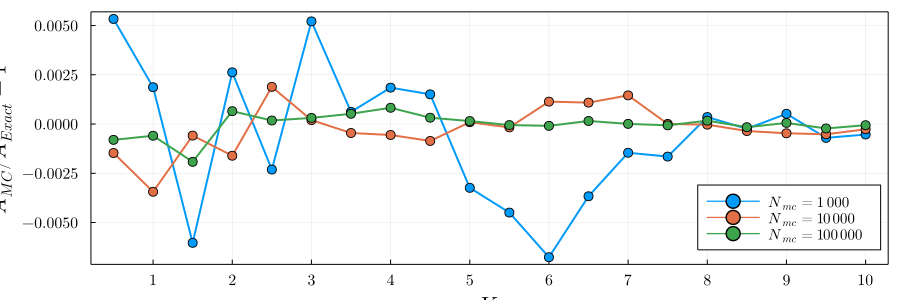

In [54]:
plot1 = plot(0.5:0.5:10,
               [relative_Nmc1K,relative_Nmc10K,relative_Nmc100K],
               label = [L"$N_{mc}=1\,000$" L"$N_{mc}=10\,000$" L"$N_{mc}=100\,000$"],
               #label = ["1K" "10K" "100K"],
               #title = ["Comparison with exact"],
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.85,0.25),
               size = (900, 300),
               ylabel = L"A_{MC}/A_{Exact} -1",
               xlabel = "K",
            #    yerror= [error_relative_Nmc1K,error_relative_Nmc10K],
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               )

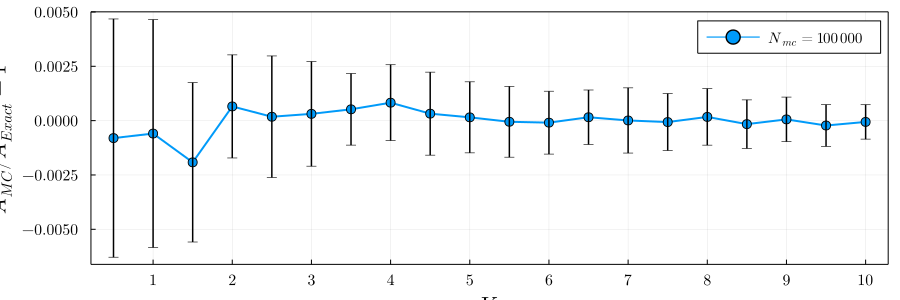

In [55]:
plot2 = plot(0.5:0.5:10,
               relative_Nmc100K,
            #   label = [L"$N_{mc}=1000$",L"$N_{mc}=1000$"],
               label =  L"$N_{mc}=100\,000$",
               #title = ["Comparison with exact"],
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.85,0.90),
               size = (900, 300),
               ylabel = L"A_{MC}/A_{Exact} -1",
               xlabel = "K",
               yerror= error_relative_Nmc100K,
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               )

In [56]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1) + c[4]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [4.0,1.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], amplitude_Nmc100K[10:end], c0)
fit.param

4-element Vector{Float64}:
  8.512197006087616
 14.851996957714121
 27.304188695111065
  4.862355436644231e6

In [57]:

margin_error(fit, 0.05)

4-element Vector{Float64}:
  0.5861875359165891
 29.96373894072971
 62.5493952938329
  4.820338199257052e6

In [58]:
function get_data_mu16(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_0.167/ib_0/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end

function get_self_energy_exact_mu16()
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/exact/BF/weight_0.167/ib_0/ampls_cutoff_10.csv",
        ),
    )
end

exact_amplitude_mu16 = get_self_energy_exact_mu16().amp[2:end];
function get_data_mu0(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_0.0/ib_0/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end

function get_self_energy_exact_mu0()
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/exact/BF/weight_0.0/ib_0/ampls_cutoff_10.csv",
        ),
    )
end

exact_amplitude_mu0 = get_self_energy_exact_mu0().amp[2:end];
function get_data_mum16(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_-0.167/ib_0/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end

function get_self_energy_exact_mum16()
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/exact/BF/weight_-0.167/ib_0/ampls_cutoff_10.csv",
        ),
    )
end

exact_amplitude_mum16 = get_self_energy_exact_mum16().amp[2:end];
layers_trials_mu16 = DataFrame()
for trial in 1:20
    layers_trials_mu16[!,"$(trial)"]=[get_data_mu16(100000, trial).amp[id] - get_data_mu16(100000, trial).amp[id-1] for id in 2:21]
end

layers_average_mu16 =  [mean(row) for row in eachrow(layers_trials_mu16)];
layers_variance_mu16 =  [var(row) for row in eachrow(layers_trials_mu16)];
amplitude_Nmc100K_mu16 = [sum(layers_average_mu16[1:id]) for id in 1:20];
error_Nmc100K_mu16 = sqrt.([sum(layers_variance_mu16[1:id]) for id in 1:20]);


relative_Nmc100K_mu16 = amplitude_Nmc100K_mu16./exact_amplitude_mu16 .-1;
error_relative_Nmc100K_mu16 = error_Nmc100K_mu16./exact_amplitude_mu16;
layers_trials_mu0 = DataFrame()
for trial in 1:20
    layers_trials_mu0[!,"$(trial)"]=[get_data_mu0(100000, trial).amp[id] - get_data_mu0(100000, trial).amp[id-1] for id in 2:21]
end

layers_average_mu0 =  [mean(row) for row in eachrow(layers_trials_mu0)];
layers_variance_mu0 =  [var(row) for row in eachrow(layers_trials_mu0)];
amplitude_Nmc100K_mu0 = [sum(layers_average_mu0[1:id]) for id in 1:20];
error_Nmc100K_mu0 = sqrt.([sum(layers_variance_mu0[1:id]) for id in 1:20]);

relative_Nmc100K_mu0 = amplitude_Nmc100K_mu0./exact_amplitude_mu0 .-1;
error_relative_Nmc100K_mu0 = error_Nmc100K_mu0./exact_amplitude_mu0;
layers_trials_mum16 = DataFrame()
for trial in 1:20
    layers_trials_mum16[!,"$(trial)"]=[get_data_mum16(100000, trial).amp[id] - get_data_mum16(100000, trial).amp[id-1] for id in 2:21]
end

layers_average_mum16 =  [mean(row) for row in eachrow(layers_trials_mum16)];
layers_variance_mum16 =  [var(row) for row in eachrow(layers_trials_mum16)];
amplitude_Nmc100K_mum16 = [sum(layers_average_mum16[1:id]) for id in 1:20];
error_Nmc100K_mum16 = sqrt.([sum(layers_variance_mum16[1:id]) for id in 1:20]);


relative_Nmc100K_mum16 = amplitude_Nmc100K_mum16./exact_amplitude_mum16 .-1;
error_relative_Nmc100K_mum16 = error_Nmc100K_mum16./exact_amplitude_mum16;

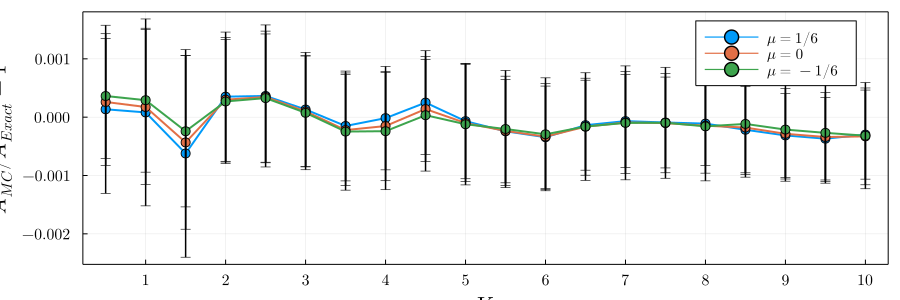

In [59]:
plot(0.5:0.5:10,
   relative_Nmc100K_mu16,
#   label = [L"$N_{mc}=1000$",L"$N_{mc}=1000$"],
   label =  L"$\mu = 1/6$",
   #title = ["Comparison with exact"],
   markershape = [:circle :circle :circle],
   shape = [:circle :circle :circle],
   xticks = 1:1:10,
   legend = (0.85,0.90),
   size = (900, 300),
   ylabel = L"A_{MC}/A_{Exact} -1",
   xlabel = "K",
   yerror= error_relative_Nmc100K_mu16,
   markerstrokewidth = 1.5,
   linewidth=2,
   markersize = 5,
   )
   
plot!(0.5:0.5:10,
   relative_Nmc100K_mu0,
#   label = [L"$N_{mc}=1000$",L"$N_{mc}=1000$"],
   label =  L"$\mu=0$",
   #title = ["Comparison with exact"],
   markershape = [:circle :circle :circle],
   shape = [:circle :circle :circle],
   xticks = 1:1:10,
   legend = (0.85,0.90),
   size = (900, 300),
   ylabel = L"A_{MC}/A_{Exact} -1",
   xlabel = "K",
   yerror= error_relative_Nmc100K_mu0,
   markerstrokewidth = 1.5,
   linewidth=2,
   markersize = 5,
   )

plot!(0.5:0.5:10,
   relative_Nmc100K_mum16,
#   label = [L"$N_{mc}=1000$",L"$N_{mc}=1000$"],
   label =  L"$\mu=-1/6$",
   #title = ["Comparison with exact"],
   markershape = [:circle :circle :circle],
   shape = [:circle :circle :circle],
   xticks = 1:1:10,
   legend = (0.85,0.90),
   size = (900, 300),
   ylabel = L"A_{MC}/A_{Exact} -1",
   xlabel = "K",
   yerror= error_relative_Nmc100K_mum16,
   markerstrokewidth = 1.5,
   linewidth=2,
   markersize = 5,
   )

In [60]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1)+c[4]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [3.0,1.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], amplitude_Nmc100K_mu16[10:end], c0)
fit.param

4-element Vector{Float64}:
  4.075524030397469
  1.2405774270943442
  6.135875270842084
 12.879432195520664

In [61]:
margin_error(fit, 0.05)

4-element Vector{Float64}:
 0.060815209055860894
 0.2852429074001332
 0.2637382465724865
 7.8004000541926155

In [62]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1)+c[4]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [3.0,1.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], amplitude_Nmc100K_mu0[10:end], c0)
fit.param

4-element Vector{Float64}:
  2.9833040220857163
  1.9292665756456284
  3.688154638565825
 -1.0559208462460272

In [63]:
margin_error(fit, 0.05)

4-element Vector{Float64}:
 0.028313011196825427
 0.1929278610025475
 0.45965886238013903
 2.6355170525472293

In [64]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1)+c[4]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [3.0,1.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], amplitude_Nmc100K_mum16[10:end], c0)
fit.param

4-element Vector{Float64}:
  1.9572414712465331
  2.7025183418844922
  0.9057560961802535
 -0.7958005491337075

In [65]:
margin_error(fit, 0.05)

4-element Vector{Float64}:
 0.020040621630656424
 0.19162850111629282
 0.7756136673150085
 1.3326239847083996